<a href="https://colab.research.google.com/github/HarishBachu/Kidney_Cancer_Subtype_Classification/blob/main/InceptionResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pkbar

In [2]:
import torch
import torchvision as tv 
from torchvision import datasets, transforms
import torch.nn as nn 
from torch.nn import functional as F
from torchsummary import summary

import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt 

import os
from tqdm import tqdm
import pkbar

In [3]:
train_dir = 'drive/MyDrive/IVP_Project_Sem6/Dataset/Training_images'
test_dir = 'drive/MyDrive/IVP_Project_Sem6/Dataset/Test_images'

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 32
classes = 5
input_shape = (3, 224, 224)

epochs = 50
# lr = 1e-5

In [6]:
train_transforms = transforms.Compose(
    [
     transforms.RandomRotation(30),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

In [7]:
trainData = datasets.ImageFolder(train_dir, transform = train_transforms)
testData = datasets.ImageFolder(test_dir, transform = test_transforms)

l_data = len(trainData)

class_dict=trainData.class_to_idx
# print(class_dict)
class_labels = class_dict.values()
# print(class_labels)

train_split = int(0.8*l_data)
val_split = l_data - train_split

trainData, valData = torch.utils.data.random_split(trainData, [train_split, val_split])

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = batch_size, shuffle = True)
valLoader = torch.utils.data.DataLoader(valData, batch_size = batch_size, shuffle = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size = batch_size, shuffle = True)

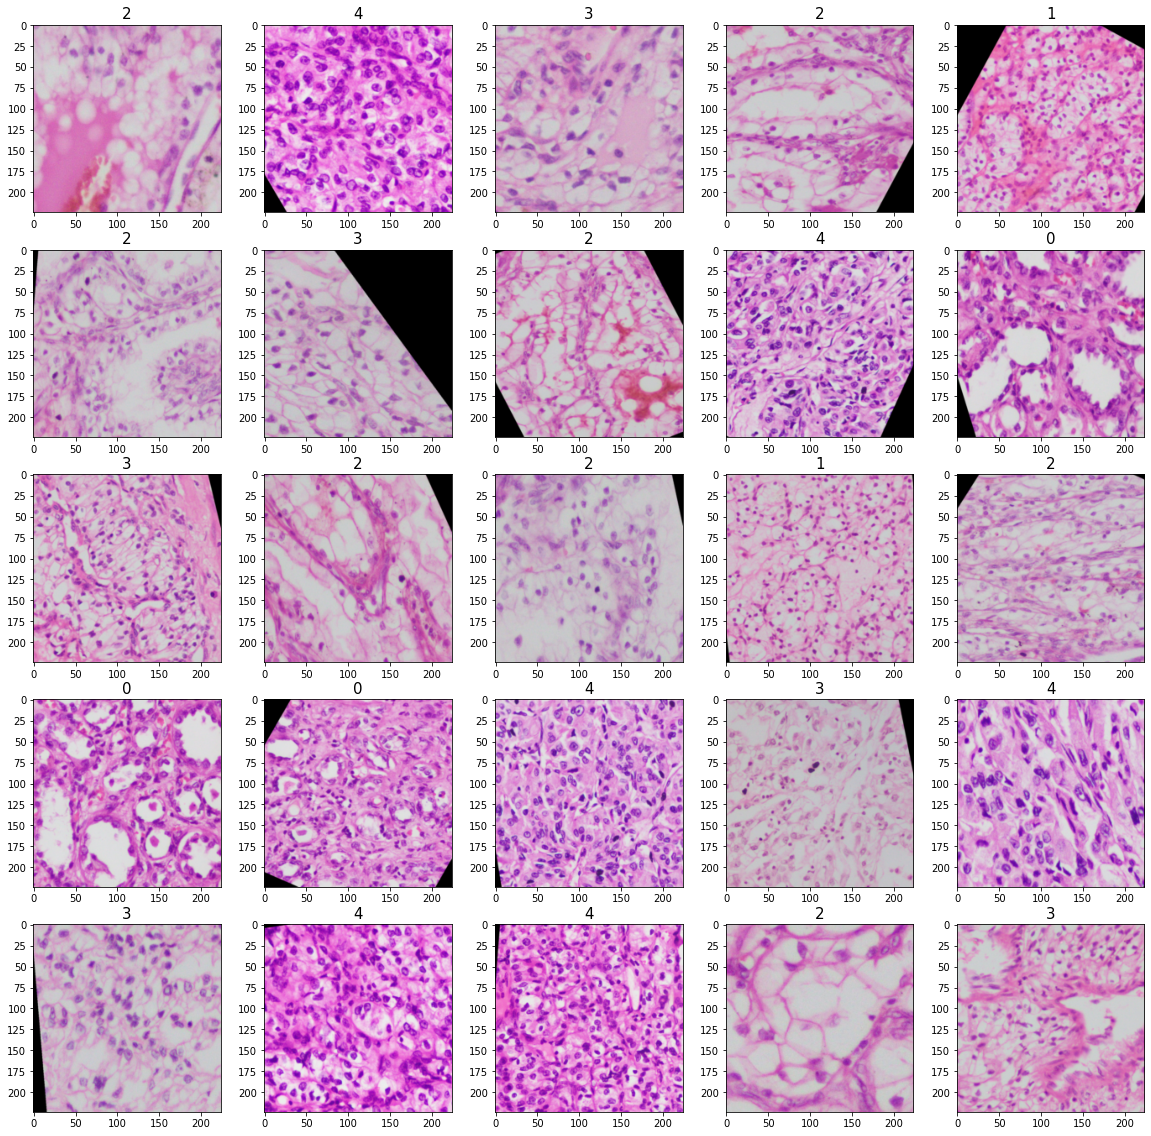

In [8]:
def plot_random_sample(loader):
    iterate = iter(loader)
    iternext = next(iterate)
    img, lab = iternext
    # print(len(img))
    fig, ax = plt.subplots(5, 5, figsize = (20, 20), )
    for i in range(5):
        for j in range(5):
            ax[i][j].imshow(img[j + 5*i].permute(2, 1, 0))
            ax[i][j].set_title(lab[j + 5*i].item(), fontsize = 15)
    
    plt.show()

plot_random_sample(trainLoader)

In [9]:
class convBlock(nn.Module):
    
    def __init__(self, in_planes, out_planes, kernel_size, padding, stride = 1, bias = False):
        super(convBlock, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride = stride, padding = padding, bias = bias)
        self.bnorm = nn.BatchNorm2d(out_planes, eps = 0.001, momentum = 0.1)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):

        x = self.conv(x)
        x = self.bnorm(x)
        x = self.relu(x)

        return x


class branch(nn.Module):

    def __init__(self, in_planes):
        super(branch, self).__init__()

        self.features = nn.Sequential(
            convBlock(in_planes, 32, 3, stride = 2, padding = 0),
            convBlock(32, 32, 3, padding = 0),
            convBlock(32, 64, 3, padding = 1),
            nn.MaxPool2d(3, stride = 2, padding = 0),
            convBlock(64, 80, 1, padding = 0),
            convBlock(80, 192, 3, padding = 0),
            nn.MaxPool2d(3, stride = 2, padding = 0)
        )

        self.b1 = convBlock(192, 96, 1, padding = 0)
        self.b2 = nn.Sequential(
            convBlock(192, 48, 1, padding = 0),
            convBlock(48, 64, 5, padding = 2)
        )
        self.b3 = nn.Sequential(
            convBlock(192, 64, 1, padding = 0),
            convBlock(64, 96, 3, padding = 1),
            convBlock(96, 96, 3, padding = 1)
        )
        self.b4 = nn.Sequential(
            nn.AvgPool2d(3, stride = 1, padding = 1, count_include_pad = False),
            convBlock(192, 64, 1, padding = 0)
        )

    def forward(self, x):
        x = self.features(x)
        x1 = self.b1(x)
        x2 = self.b2(x)
        x3 = self.b3(x)
        x4 = self.b4(x)

        return torch.cat((x1, x2, x3, x4), dim = 1)

class Inception_A(nn.Module):

    def __init__(self, in_planes, scale = 1.0):
        super(Inception_A, self).__init__()
        self.scale = scale

        self.b1 = convBlock(in_planes, 32, 1, padding = 0)
        self.b2 = nn.Sequential(
            convBlock(in_planes, 32, 1, padding = 0),
            convBlock(32, 32, 3, padding = 1)
        )

        self.b3 = nn.Sequential(
            convBlock(in_planes, 32, 1, padding = 0),
            convBlock(32, 48, 3, padding = 1),
            convBlock(48, 64, 3, padding = 1)
        )

        self.conv = nn.Conv2d(128, 320, 1, stride = 1, padding = 0, bias = True)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        x3 = self.b3(x)
        concat = torch.cat((x1, x2, x3), dim = 1)
        res = self.conv(concat)
        return self.relu(x + self.scale * res)

class Inception_B(nn.Module):

    def __init__(self, in_planes, scale = 1.0):
        super(Inception_B, self).__init__()
        self.scale = scale
        self.b1 = convBlock(in_planes, 192, 1, padding = 0)
        
        self.b2 = nn.Sequential(
            convBlock(in_planes, 128, 1, padding = 0),
            convBlock(128, 160, (1, 7), padding = (0, 3)),
            convBlock(160, 192, (7, 1), padding = (3, 0))
        )

        self.conv = nn.Conv2d(384, 1088, 1, stride = 1, padding = 0, bias = True)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        concat = torch.cat((x1, x2), dim = 1)
        res = self.conv(concat)
        return self.relu(x + self.scale * res)

class Inception_C(nn.Module):

    def __init__(self, in_planes, scale = 1.0, activation = True):
        super(Inception_C, self).__init__()
        self.scale = scale
        self.activation = activation
         
        self.b1 = convBlock(in_planes, 192, 1, padding = 0)

        self.b2 = nn.Sequential(
            convBlock(in_planes, 192, 1, padding = 0),
            convBlock(192, 224, (1, 3), padding = (0, 1)),
            convBlock(224, 256, (3, 1), padding = (1, 0))
        )

        self.conv = nn.Conv2d(448, 2080, 1, stride = 1, padding = 0, bias = True)
        self.relu = nn.ReLU(inplace = True)
         
    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        concat = torch.cat((x1, x2), dim = 1)
        res = self.conv(concat)
        if self.activation:
            return self.relu(x + self.scale * res)
        return x + self.scale * res


class Reduce_A(nn.Module):

    def __init__(self, in_planes, a, b, c, d):
        super(Reduce_A, self).__init__()
        
        self.b1 = convBlock(in_planes, d, 3, stride = 2, padding = 0)

        self.b2 = nn.Sequential(
            convBlock(in_planes, a, 1, padding = 0),
            convBlock(a, b, 3, padding = 1),
            convBlock(b, c, 3, stride = 2, padding = 0)
        )

        self.b3 = nn.MaxPool2d(3, stride = 2, padding = 0)

    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        x3 = self.b3(x)
        return torch.cat((x1, x2, x3), dim = 1)


class Reduce_B(nn.Module):

    def __init__(self, in_planes):
        super(Reduce_B, self).__init__()

        self.b1 = nn.Sequential(
            convBlock(in_planes, 256, 1, padding = 0),
            convBlock(256, 384, 3, stride = 2, padding = 0)
        )

        self.b2 = nn.Sequential(
            convBlock(in_planes, 256, 1, padding = 0),
            convBlock(256, 288, 3, stride = 2, padding = 0)
        )

        self.b3 = nn.Sequential(
            convBlock(in_planes, 256, 1, padding = 0),
            convBlock(256, 288, 3, padding = 1),
            convBlock(288, 320, 3, stride = 2, padding = 0)
        )

        self.b4 = nn.MaxPool2d(3, stride = 2, padding = 0)

    def forward(self, x):

        x1 = self.b1(x)
        x2 = self.b2(x)
        x3 = self.b3(x)
        x4 = self.b4(x)
        return torch.cat((x1, x2, x3, x4), dim = 1)

    
class InceptionResNetV2(nn.Module):

    def __init__(self, in_planes = 3, n_classes = 5, a = 256, b = 256, c = 384, d = 384):
        super(InceptionResNetV2, self).__init__()

        blocks = []
        blocks.append(branch(in_planes))
        for i in range(10):
            blocks.append(Inception_A(320, 0.17))
        
        blocks.append(Reduce_A(320, a, b, c, d))

        for i in range(20):
            blocks.append(Inception_B(1088, 0.10))
        
        blocks.append(Reduce_B(1088))

        for i in range(9):
            blocks.append(Inception_C(2080, 0.20))

        blocks.append(Inception_C(2080, activation = False))

        self.features = nn.Sequential(*blocks)
        self.conv = convBlock(2080, 1536, 1, padding = 0)
        self.gAvgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.dense = nn.Linear(1536, n_classes)

    def forward(self, x):

        x = self.features(x)
        x = self.conv(x)
        x = self.gAvgPool(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)

        return x


In [10]:
model = InceptionResNetV2(n_classes = 5)
model.to(device)

InceptionResNetV2(
  (features): Sequential(
    (0): branch(
      (features): Sequential(
        (0): convBlock(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bnorm): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): convBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (bnorm): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (2): convBlock(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bnorm): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): convBlock(
          (conv): Conv2d(64, 80

In [11]:
summary(model, input_size = input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
         convBlock-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
         convBlock-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
        convBlock-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [12]:
def save_checkpoint(model, optimizer, to_file):
    checkpoint = {'state_dict' : model.state_dict(),
                  'optimizer_dict' : optimizer.state_dict}
    torch.save(checkpoint, to_file)

def load_checkpoint(model, optimizer, from_file):
    checkpoint = torch.load(from_file, map_location = torch.device(device))
    model.load_state_dict(checkpoint['state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_dict'])
    return model

def accuracy(prediction, label):

    n_correct = 0
    n_samples = 0
    _, preds = prediction.max(1)
    n_correct += (preds == label).sum()
    n_samples = preds.size(0)

    return n_correct/n_samples

In [13]:
n_trainBatches = len(trainLoader)
n_valBatches = len(valLoader)
min_loss = np.inf

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

model_path = "/content/drive/MyDrive/IVP_Project_Sem6/Dataset/InceptionResNetV2_checkpoint.pth.tar"
for epoch in range(epochs):

    train_loss = []
    val_loss = []
    # train_acc = []
    # val_acc = []

    train_loop, val_loop = enumerate(trainLoader), enumerate(valLoader)

    # train_loop = tqdm(trainLoader, ascii = True, desc = "Epoch {}/{}".format(epoch+1, epochs), ncols = 100)
    # val_loop = tqdm(valLoader, ascii = True, desc = "Vaidation Epoch {}/{}".format(epoch+1, epochs), ncols = 100)
    
    train_bar = pkbar.Kbar(target = n_trainBatches, epoch = epoch, num_epochs = epochs)
    val_bar = pkbar.Kbar(target = n_valBatches, epoch = epoch, num_epochs = epochs)

    for idx, (data, label) in train_loop:

        model.train()
        data, label = data.to(device), label.to(device)

        prediction = model(data)

        t_loss = loss_fn(prediction, label)
        train_loss.append(t_loss.item())

        optimizer.zero_grad()
        t_loss.backward()

        optimizer.step()

        t_acc = accuracy(prediction, label)
        # train_acc.append(t_acc.item())

        train_bar.update(idx, values = [("loss", t_loss.item()), ("acc", t_acc.item())])
    train_bar.update(n_trainBatches, values = None)
    
    for idx, (val_data, val_label) in val_loop:

        val_data = val_data.to(device)
        val_label = val_label.to(device)
        model.eval()
        prediction = model(val_data)
        v_loss = loss_fn(prediction, val_label)
        val_loss.append(v_loss.item())
        v_acc = accuracy(prediction, val_label)
        # val_acc.append(v_acc.item())

        val_bar.update(idx, values = [("val_loss", v_loss.item()), ("val_acc", v_acc.item())])
        if np.mean(val_loss) < min_loss:
            min_loss = v_loss.item()
            print("Current Checkpoint Loss: {:.4f}".format(min_loss))
            print("Saving Model ...")
            save_checkpoint(model, optimizer, model_path)
            print("Model Saved at: {}".format(model_path))
    val_bar.update(n_valBatches, values = None)



Epoch: 1/50
Epoch: 1/50
0/2 [..............................] - ETA: 0s - val_loss: 0.0000e+00 - val_acc: 0.0000e+00Current Checkpoint Loss: 2.7656
Saving Model ...
Model Saved at: /content/drive/MyDrive/IVP_Project_Sem6/Dataset/InceptionResNetV2_checkpoint.pth.tar
1/2 [==============>...............] - ETA: 2:56 - val_loss: 1.6401 - val_acc: 0.0000e+00  Current Checkpoint Loss: 1.6401
Saving Model ...
Model Saved at: /content/drive/MyDrive/IVP_Project_Sem6/Dataset/InceptionResNetV2_checkpoint.pth.tar
2/2 [==============================] - 180s 90s/step - val_loss: 1.6401 - val_acc: 0.0000e+00
Epoch: 2/50
Epoch: 2/50
2/2 [==============================] - 160s 80s/step - val_loss: 3.2074 - val_acc: 0.3333
Epoch: 3/50
Epoch: 3/50
2/2 [==============================] - 157s 78s/step - val_loss: 2.6400 - val_acc: 0.0000e+00
Epoch: 4/50
Epoch: 4/50
2/2 [==============================] - 158s 79s/step - val_loss: 8.5114 - val_acc: 0.0000e+00
Epoch: 5/50
Epoch: 5/50
2/2 [=====================

In [14]:
inresnet50= load_checkpoint(model, optimizer, model_path)

In [15]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model_a, class_labels):

    model_a.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model_a(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [19]:
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(valLoader, inresnet50, class_labels)

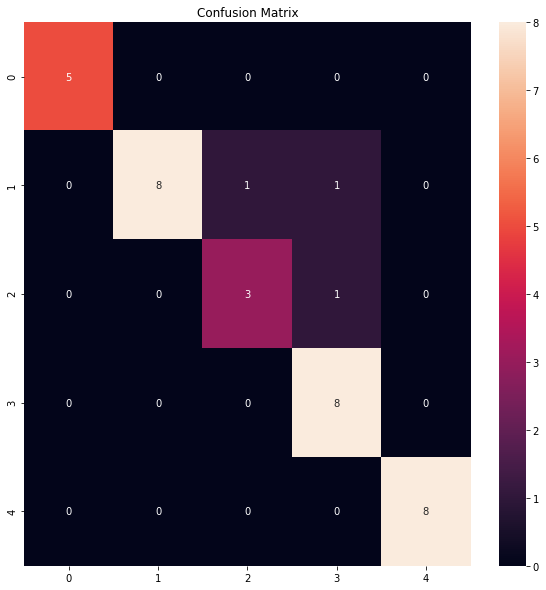

In [22]:
# print('CONFUSION MATRIX:\n',confusion_matrix,'\n')

# print("PRECISION:",precision)
# print("RECALL:",recall)
# print("F1 SCORE:",f1)
# print("ACCURACY:",accuracy)

import pandas as pd
import seaborn as sns

df = pd.DataFrame(confusion_matrix, index = [i for i in range(5)], columns = [i for i in range(5)])
plt.figure(figsize = (10, 10))
plt.title("Confusion Matrix")
sns.heatmap(df, annot = True)

In [23]:
print("PRECISION:",np.mean(precision))
print("RECALL:",np.mean(recall))
print("F1 SCORE:",np.mean(f1))
print("ACCURACY:",np.mean(accuracy))

PRECISION: 0.9099999999999999
RECALL: 0.9099999999999999
F1 SCORE: 0.9055555555555556
ACCURACY: 0.9657142857142856
